In [1]:
#!pip install tensorflow==2.0.0b1


In [2]:
import json
import tensorflow as tf
from keras.optimizers import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint

print(tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

2.0.0-beta0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [15]:
version=6
model_name="sarcasm_model"+"_v"+str(version)

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#training_size = 1990000

batch_size=128
epochs=10



load_weights=False
load_checkpoint=False
do_training=True
save_model=True

model_file=model_name+".h5"



In [16]:
#
#  Loading/Munging Raw Data to Memory
#

# in-memory storage
sentences = [] #x1
context = []   #x2
labels = []    #y1
urls = []

# Getting sarcasm_data.json
download_data=False
if(download_data):
    !wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json               
        
def clean_line(line):
    try:
        line.lower()
    except:
        print("failed to lower: "+str(line))            
    
    line = " ".join(line.split())
    line = line.strip()
    line = line.replace("[_-]", ' ')
    line = line.replace("\'", '')
    line = line.replace("at&amp;t", "at&t")
                        
    return line
        
def parseJsonToMemory(filename, labelField, commentField, contextField):
    print(f'Loading {filename}')
    with open("./data/sarcasm_data.json", 'r') as f:
        datastore = json.load(f)

        for item in datastore:
            sentences.append(item[commentField])
            labels.append(int(item[labelField]))
            if contextField == -1 :
                context.append("")
            else:
                context.append(row[contextField])
    print(f'Loaded {filename}')
    print("  sentences len: "+str(len(sentences)))
    print("  labels len: "+str(len(labels)))
    print("  context len: "+str(len(context)))
    
def joinArray(arr):
    s = " "
    s = s.join(arr)
    return s

def parseJsonToMemory2(filename, labelField, commentField, contextField):
    print(f'Loading {filename}')
    with open("./data/sarcasm_data.json", 'r') as f:
        datastore = json.load(f)

        for item in datastore:
            sentences.append(item[commentField])
            labels.append(int(item[labelField]))
            context.append(joinArray(item[contextField]))
            
    print(f'Loaded {filename}')
    print("  sentences len: "+str(len(sentences)))
    print("  labels len: "+str(len(labels)))
    print("  context len: "+str(len(context)))
  
import csv 
def parseCSVToMemory(filename, labelCol, commentCol, contextCol):
    print(f'Loading {filename}')
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            #print(f'\t label: {row[labelCol]} of {type(row[labelCol])} sentence: {row[commentCol]} context: {row[contextCol]}')
            try:
                if line_count == 0:
                    print(f'  Column names are {", ".join(row)}')
                    line_count += 1
                else:
                    
                    labels.append(int(row[labelCol]))
                    sentences.append(row[commentCol])
                    line_count += 1
                    if contextCol == -1 :
                        context.append("")
                    else:
                        context.append(row[contextCol])               
            except:
                print("error parsing label: " + row[labelCol] + " comment: " + row[commentCol])        
        print(f'Loaded {filename} w/ {line_count} lines.')
        print("  sentences len: "+str(len(sentences)))
        print("  labels len: "+str(len(labels)))
        print("  context len: "+str(len(context)))

# add working w/ tensors data
parseJsonToMemory('./data/sarcasm_data.json', 'is_sarcastic', 'headline', -1)

#add kaggle data
parseCSVToMemory('./data/sarcasm_kaggle.csv', 0, 1, -1)

#add reddit data
parseCSVToMemory('./data/train-balanced-sarcasm.csv', 0, 1, 9)

#TODO: doesn't parse correctly
#parseJsonToMemory2('./data/sarcasm_data_mustard.json', "sarcasm", "utterance", "context") 
                          
# output to this sections
x_all=sentences
y_all=labels

print("Done Loading/Munging Raw Data")


Loading ./data/sarcasm_data.json
Loaded ./data/sarcasm_data.json
  sentences len: 26709
  labels len: 26709
  context len: 26709
Loading ./data/sarcasm_kaggle.csv
  Column names are label, comment
Loaded ./data/sarcasm_kaggle.csv w/ 1010819 lines.
  sentences len: 1037527
  labels len: 1037527
  context len: 1037527
Loading ./data/train-balanced-sarcasm.csv
  Column names are label, comment, author, subreddit, score, ups, downs, date, created_utc, parent_comment
Loaded ./data/train-balanced-sarcasm.csv w/ 1010827 lines.
  sentences len: 2048353
  labels len: 2048353
  context len: 2048353
Done Loading/Munging Raw Data


In [19]:
#
#  Processing Data
#

# shuffle

# combine x and y cols
def concat_cols(x,y):
    y = y.reshape(y.shape[0],1)
    return np.concatenate((x,y), axis=1)

# split x and y
def split_cols(a):
    x_res = a[:,0:a.shape[1]-1]
    y_res = a[:,a.shape[1]-1:a.shape[1]]
    return x_res, y_res

# shuffle rows of a
def shuffle(a, subset_size):
    subset = a[np.random.choice(a.shape[0], subset_size, replace=False), :]
    return subset
                  
# generates random subset of x,y
# x: x records
# y: y labels
# subset_size:  subset size
def generate_shuffled_subset(x, y, subset_size):    
    combined = concat_cols(x,y)
    assert( subset_size < combined.shape[0])
    subset = shuffle(combined, subset_size)
    x_res = subset[:,0:x.shape[1]]
    y_res = subset[:,subset.shape[1]-1:subset.shape[1]]
    return x_res, y_res

train_ratio=.93
test_ratio=.05
holdout_ratio=.02

train_size=int(len(x_all)*train_ratio)
test_size=int(len(x_all)*test_ratio)
holdout_size=int(len(x_all)*test_ratio)
print("train_size: "+str(train_size))
print("test_size: "+str(test_size))
print("holdout_size: "+str(holdout_size))

#TODO:  WIP i.e. doesn't work
x_all, y_all = generate_shuffled_subset(x_all, y_all, len(x_all))

x_train = x_all[0:training_size]
y_train = y_all[0:training_size]

x_test = x_all[training_size:(training_size+test_size)]
y_test = y_all[training_size:(training_size+test_size)]

x_holdout = x_all[training_size:(test_size+holdout_size)]
y_holdout = y_all[training_size:(test_size+holdout_size)]

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
print(testing_sentences[0:5])
print(testing_labels[0:5])

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

def sentencesToPaddedSequences(sentences):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded_sequences

training_padded = sentencesToPaddedSequences(training_sentences)
print("training_padded.shape: "+str(training_padded.shape))
print(str(training_padded))
print(type(training_padded))

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = sentencesToPaddedSequences(testing_sentences)
print("testing_padded.shape: "+str(testing_padded.shape))
print(type(testing_padded))

print("type of test labels: " + str(type(testing_labels)))
print("type of training labels: " + str(type(training_labels)))


train_size: 1904968
test_size: 102417
holdout_size: 102417


AttributeError: 'list' object has no attribute 'reshape'

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
if(load_weights):
    print("loading weights from: "+model_file)
    model.load_weights(model_file)
    print("weights: ")
    #print(str(model.get_weights()))
    print("loading weights complete!")
    
if(load_checkpoint):
    model.load_weights('./'+model_name+'-weights-checkpoint.h5')
    print("loaded checkpoint")

In [9]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 256)          148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 735,745
Trainable params: 735,745
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpointer = ModelCheckpoint(filepath='./'+model_name+'-weights-checkpoint.h5', verbose=2, save_best_only=True)

if(do_training):
    history = model.fit(training_padded, 
                        training_labels, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_data=(testing_padded, testing_labels),
                        callbacks=[checkpointer],
                        verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1990000 samples, validate on 58353 samples
Epoch 1/10
1989888/1990000 [============================>.] - ETA: 0s - loss: 0.5486 - accuracy: 0.7174
Epoch 00001: val_loss improved from inf to 0.51428, saving model to ./sarcasm_model_v4-weights-checkpoint.h5
1990000/1990000 [==============================] - 10025s 5ms/sample - loss: 0.5486 - accuracy: 0.7174 - val_loss: 0.5143 - val_accuracy: 0.7413
Epoch 2/10
1989888/1990000 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.7424
Epoch 00002: val_loss improved from 0.51428 to 0.49697, saving model to ./sarcasm_model_v4-weights-checkpoint.h5
1990000/1990000 [==============================] - 9763s 5ms/sample - loss: 0.5151 - accuracy: 0.7424 - val_loss: 0.4970 - val_accuracy: 0.7542
Epoch 3/10
1989888/1990000 [============================>.] - ETA: 0s - loss: 0.4928 - accuracy: 0.7583
Epoch 00003: val_loss improved 

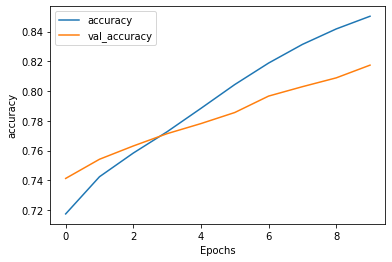

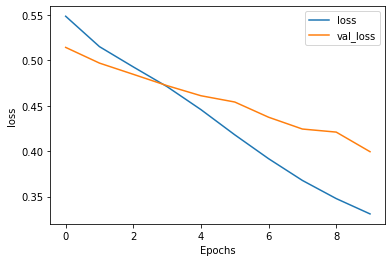

In [14]:
if(do_training):
    import matplotlib.pyplot as plt

    #print(str(history.history))
    def plot_graphs(history, string):
      plt.plot(history.history[string])
      plt.plot(history.history['val_'+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, 'val_'+string])
      plt.show()

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

In [12]:
if(save_model):
    model.save(model_file)

In [22]:
# prediction

x_pred_sentences = ["that dress looks so cute on you", 
                    "great, more work", 
                    "phantom menace was the best movie ever",
                    "you are so badass",
                    "your hair looks great",
                    "i really respect you professionally",
                    "deathstradding makes total sense!",
                    "yeah, eating babies is a fantastic idea",
                    "ryan gosling is the best actor"]
x_padded_sequence = sentencesToPaddedSequences(x_pred_sentences)
pred = model.predict(x_padded_sequence)
print(pred)

[[0.15094757]
 [0.49740618]
 [0.94168407]
 [0.9979384 ]
 [0.3782035 ]
 [0.09248951]
 [0.9208846 ]
 [0.969754  ]
 [0.3192356 ]]
